<a href="https://colab.research.google.com/github/kshitizs11/GAN-Generative-adversarial-network-/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from keras.datasets import cifar10
from keras.datasets.fashion_mnist import load_data

In [ ]:
# (x_train, y_train),(x_test, y_test) = cifar10.load_data()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# x_train.shape,y_train.shape,x_test.shape,y_test.shape

In [ ]:
# for i in range(100):
# 	# define subplot
# 	plt.subplot(10, 10, 1 + i)
# 	# turn off axis
# 	plt.axis('off')
# 	# plot raw pixel data
# 	plt.imshow(x_train[i], cmap='gray_r')
# plt.show()

In [ ]:
from keras.layers import Dense,Reshape,Flatten,Dropout,LeakyReLU,Conv2D,Conv2DTranspose,Input,Embedding,Concatenate
from keras.optimizers import Adam
from keras.models import Sequential,Model
import numpy as np
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
# from keras.datasets.cifar10 import load_data

In [ ]:
# np.unique(y_train)

# Discriminator

# Here WE Are Converting All the Classes to a embedding of 50 after that we are Passing it to dense layer and than reshape it to one single image size so that we can concatenate it to other images and that get the result of one single number that how close this image is to original image

In [ ]:
def define_discriminator(in_shape=(28,28,1),n_classes=10):
  in_label = Input(shape=(1,))
  #Embedding
  li = Embedding(n_classes,50)(in_label)
  n_nodes = in_shape[0]*in_shape[1]
  #Scale Up To Image Dimension With Linear Activation
  li = Dense(n_nodes)(li)
  # Reshape The Additional Channel
  li = Reshape((in_shape[0],in_shape[1],1))(li)
  #Image Input
  in_image = Input(shape=in_shape)
  #Concate Labels & Image Input
  merge = Concatenate()([in_image,li])
  #DownSample
  fe = Conv2D(128,(3,3),strides=(2,2),padding="same")(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  #DownSample
  fe = Conv2D(128,(3,3),strides=(2,2),padding="same")(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  #Flatten
  fe = Flatten()(fe)
  #Dropout
  fe = Dropout(0.3)(fe)
  #Output
  out_layer = Dense(1,activation="sigmoid")(fe)
  #Define Model
  model = Model([in_image,in_label],out_layer)
  #Compile Model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# Generator

# Than in this we are creating an extra layer in the image before going into the Actuall Image Basd Model This Extra layer contains the embedding of the all category of the unique labels in the data and also remeber that here the images basically is 100 dimension random vector

In [ ]:
def define_generator(latent_dim,n_classes=10):
  #lable_input
  in_label = Input(shape=(1,))
  # Embedding For Categorical Input
  li = Embedding(n_classes,50)(in_label)
  # Linear Multiplication
  n_nodes = 7*7
  li = Dense(n_nodes)(li)
  #Reshape To Additional Channel
  li = Reshape((7,7,1))(li)
  # Image Generator Input
  in_lat = Input(shape=(latent_dim,))
  # Foundation For 7*7 Images
  n_nodes = 128*7*7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7,7,128))(gen)
  # Merge Image Gen & Label Input
  merge = Concatenate()([gen,li])
  # Upsample 14*14
  gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding="same")(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Upsample 28*28
  gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding="same")(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Output
  out_layer = Conv2D(1,(7,7),activation="tanh",padding="same")(gen)
  # Define Model
  model = Model([in_lat,in_label],out_layer)
  return model

# Main Model

# Here is the actuall model where we freeze the D and just gonna train the G on the image of noise and create your new image

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model,d_model):
  # Make Weights In Discriminator False
  d_model.trainable = False
  # Get Noise & Label input From Generator Model
  gen_noise,gen_label = g_model.input
  # Get Image Output From Generator Model
  gen_output = g_model.output
  # Connect Image Output & Label Input From Generator as Inputs To Discriminator
  gan_output = d_model([gen_output,gen_label])
  # Define GAN Model as taking noise and label and otputting a classification
  model = Model([gen_noise,gen_label],gan_output)
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=opt)
  return model

In [ ]:
# x = expand_dims(x_train,axis=1)
# x = x.astype("float32")
# x = (x - 127.5)/127.5

# Load Data

# Here WE are just loading data

In [ ]:
def load_real_samples():
  (x_train,y_train),(x_test,y_test) = load_data()
  # x_train.append(x_test)
  # y_train.append(y_test)
  x = expand_dims(x_train,axis=-1)
  # print(x.shape)
  # print(y_train.shape)
  x = x.astype("float32")
  x = (x-127.5)/127.5
  return [x,y_train]

# After loading the data here we are Selecting three things the random images the random labels of those selected images (what that image is) and than load that many ones because these are the real samples

In [ ]:
def generate_real_samples(dataset,n_samples):
  # split into images and labels
  images,labels = dataset
  # choose random instances
  ix = randint(0,images.shape[0],n_samples)
  # select images and labels
  x,labels = images[ix],labels[ix]
  # generate class labels
  y = ones((n_samples,1))
  return [x,labels],y

# Here we are generating the fake or we say random vectors which are going to be the image after passing through the generator other than this we are also creating the labels for those images so that on the basis of this we are going to create the image basically these randint are the labels 

In [ ]:
def generate_latent_points(latent_dim,n_samples,n_classes=10):
  # Generate Points In The Latent Space
  x_input = randn(latent_dim*n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples,latent_dim)
  # Generate Labels
  labels = randint(0,n_classes,n_samples)
  return [z_input,labels]

# Here by using those latent spaces we generated above we are going to create the images and these images are going to be test by the D here we are also creating zeros as well because they are fake images

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# Here we training the models by using the images and labels

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

# Here we are just calling the functions

In [ ]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>90, 150/468, d1=0.708, d2=0.713 g=0.751
>90, 151/468, d1=0.707, d2=0.701 g=0.803
>90, 152/468, d1=0.684, d2=0.689 g=0.807
>90, 153/468, d1=0.648, d2=0.669 g=0.744
>90, 154/468, d1=0.704, d2=0.729 g=0.759
>90, 155/468, d1=0.689, d2=0.680 g=0.773
>90, 156/468, d1=0.671, d2=0.680 g=0.830
>90, 157/468, d1=0.707, d2=0.713 g=0.784
>90, 158/468, d1=0.694, d2=0.719 g=0.770
>90, 159/468, d1=0.682, d2=0.669 g=0.776
>90, 160/468, d1=0.710, d2=0.657 g=0.811
>90, 161/468, d1=0.708, d2=0.679 g=0.757
>90, 162/468, d1=0.647, d2=0.671 g=0.797
>90, 163/468, d1=0.718, d2=0.671 g=0.780
>90, 164/468, d1=0.666, d2=0.679 g=0.738
>90, 165/468, d1=0.692, d2=0.674 g=0.770
>90, 166/468, d1=0.691, d2=0.641 g=0.759
>90, 167/468, d1=0.698, d2=0.707 g=0.761
>90, 168/468, d1=0.690, d2=0.676 g=0.771
>90, 169/468, d1=0.704, d2=0.705 g=0.761
>90, 170/468, d1=0.696, d2=0.698 g=0.756
>90, 171/468, d1=0.667, d2=0.646 g=0.767
>90, 172/468, d1=0.662, d2=0.639 g=0.773
>90, 1

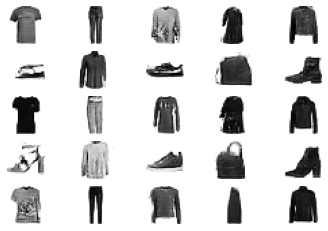

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 5)